In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4
IN_CHANNELS = 1
N_CLASSES = 1
EPOCH =200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = None

#### head

In [7]:
ACT = "sigmoid"
AUX_PARAM = None

### Optimizer Settings

In [8]:
OPTIM_NAME = "adam"
init_lr = 3e-4
momentum = 0.9

# Epochs

In [9]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor

In [10]:
def train_epoch(model, optimizer, dataloader, device):
  
    # change mode to train and move to current device
    model = model.train().to(device)

    ssim_l = 0
    mae_l = 0
    mask_l = 0
    for index, data in tqdm(enumerate(dataloader)):
        
        _, y, _, mask_y, *_ = data

        y = y.to(device)
        mask_y = mask_y.to(device)

        y_pr = model(y)
        y_pr = Activation(name=ACT)(y_pr) # zipped value to [0, 1]

        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        y_min = -500
        y_max = 500
        upper = ((-256) - (y_min))/(y_max-(y_min))
        lower = ((-257) - (y_min))/(y_max-(y_min))
        mask_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        _mask = nn.BCELoss()(mask_pr.float(), mask_y.float())
        
        _loss = _ssim + _mae + _mask
                        
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        mask_l += _mask.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()

    return  mae_l/(index+1), ssim_l/(index+1), mask_l/(index+1)

In [11]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    mask_ = []
    for index, data in tqdm(enumerate(dataloader)):

        _, y, _, mask_y, _, _, y_min, y_max = data


        y = y.to(device)
        mask_y = mask_y.to(device)

        y_pr = model(y)
        y_pr = Activation(name=ACT)(y_pr) # zipped value to [0, 1]

        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]

        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        mask_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(mask_pr, mask_y)
        
        mask_ += [dice.item()]
        
    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), sum(mask_)/len(mask_)

In [12]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        _, y, _, mask_y, _, _, y_min, y_max = data


        y = y.to(device)
        mask_y = mask_y.to(device)

        y_pr = model(y)
        y_pr = Activation(name=ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        mask_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_mask = mask_y[b, :, :, :].unsqueeze(0)
            tmp_mask_pr = mask_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _dice = Fscore()(tmp_mask_pr, tmp_mask)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("mask dice score = {}".format(_dice.item()))
            

            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __mask = (tmp_mask.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __mask_pr = (tmp_mask_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                ct_y = __ct,
                ct_pred = __ct_pred,
                mask = __mask,
                mask_pr = __mask_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                os.mkdir(path_dir)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "mask.jpg"), __mask)
                cv2.imwrite(os.path.join(path_dir, "mask_pred.jpg"), __mask_pr)
                  
            iid += 1

# Read Data

In [13]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [14]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [15]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [16]:
len(trainset), len(testset)

(1344, 191)

In [17]:
x, y, mask_x, mask_y, *_ = trainset[20]

In [18]:
np.min(mask_y)

0.0

In [19]:
np.max(mask_y)

1.0

(<matplotlib.image.AxesImage at 0x7f2490a87ee0>,)

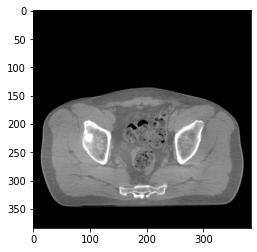

In [20]:
plt.imshow(x.squeeze(), 'gray'),

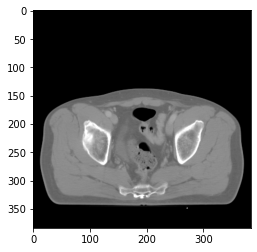

In [21]:
plt.imshow(y.squeeze(), 'gray')

In [22]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

## Model

In [23]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, head):
        
        super(Model, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.head = head
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Running

In [24]:
import wandb

wandb.init(project="ct_rebuild", config={
    "data": {
        "in_channels": IN_CHANNELS,
        "out_channels": N_CLASSES,
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "optimizer": OPTIM_NAME,
        "init_lr": init_lr,
        "momentum": momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": ACT,
        "decoder_attention_type": DECODER_ATT
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [25]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [26]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

encoder = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=IN_CHANNELS, classes=N_CLASSES)
encoder = encoder.encoder

decoder = UnetDecoder(
                            encoder_channels=[IN_CHANNELS, 0, 0, 0, 0, 2048],
                            decoder_channels=[256, 128, 64, 32, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=DECODER_ATT)

head = SegmentationHead(
                        in_channels=16,
                        out_channels=1,
                        activation=None)


model = Model(encoder, decoder, head)

del encoder, decoder, head

In [27]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
optimizer = Optimizer(model.parameters(), name=OPTIM_NAME, lr=init_lr)

In [28]:
wandb.watch(model)

min_mae = 99999

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_mask = train_epoch(model, optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_mask_train = eval_epoch(model, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test = eval_epoch(model, testloader, device)

        wandb.log({
            "ssim loss": loss_ssim,
            "mae loss": loss_mae,
            "loss mask": loss_mask,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_mask_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_mask_test
        })
        
        
        if score_mae_test < min_mae:
            min_mae = score_mae_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("{}.pth".format(wandb.run.name)))

336it [01:01,  5.45it/s]
336it [00:17, 19.27it/s]
48it [00:02, 18.04it/s]
336it [01:01,  5.50it/s]
336it [00:17, 19.24it/s]
48it [00:02, 18.18it/s]
336it [01:02,  5.42it/s]
336it [00:17, 18.98it/s]
48it [00:02, 17.92it/s]
336it [01:01,  5.46it/s]
336it [00:17, 19.20it/s]
48it [00:02, 17.91it/s]
336it [01:01,  5.42it/s]
336it [00:17, 19.22it/s]
48it [00:02, 18.03it/s]
336it [01:01,  5.44it/s]
336it [00:17, 19.10it/s]
48it [00:02, 17.97it/s]
336it [01:01,  5.42it/s]
336it [00:17, 19.21it/s]
48it [00:02, 17.94it/s]
336it [01:01,  5.42it/s]
336it [00:17, 19.11it/s]
48it [00:02, 18.09it/s]
336it [01:02,  5.39it/s]
336it [00:17, 19.19it/s]
48it [00:02, 17.91it/s]
336it [01:01,  5.42it/s]
336it [00:17, 19.05it/s]
48it [00:02, 17.94it/s]
336it [01:01,  5.44it/s]
336it [00:17, 19.23it/s]
48it [00:02, 18.04it/s]
336it [01:02,  5.38it/s]
336it [00:17, 19.20it/s]
48it [00:02, 17.88it/s]
336it [01:01,  5.44it/s]
336it [00:17, 18.91it/s]
48it [00:02, 17.86it/s]
336it [01:02,  5.41it/s]
336it [00:17,

In [29]:
run_name = wandb.run.name
# run_name = "apricot-puddle-56"

In [30]:
checkpoint = torch.load(os.path.join("{}.pth".format(run_name)))

In [32]:
encoder = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=IN_CHANNELS, classes=N_CLASSES)
encoder = encoder.encoder

decoder = UnetDecoder(
                            encoder_channels=[IN_CHANNELS, 0, 0, 0, 0, 2048],
                            decoder_channels=[256, 128, 64, 32, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=DECODER_ATT)

head = SegmentationHead(
                        in_channels=16,
                        out_channels=1,
                        activation=None)


model = Model(encoder, decoder, head)

del encoder, decoder, head

In [34]:
try:
    os.mkdir(os.path.join("eval-autoencoder", run_name))
except FileExistsError:
    print("file exists")

0it [00:00, ?it/s]

ssim score = 0.5274649262428284
psnr score = 9.026264190673828
snr score = -0.9107974171638489
mae error = 0.20281095802783966
mask dice score = 1.904979616714472e-12


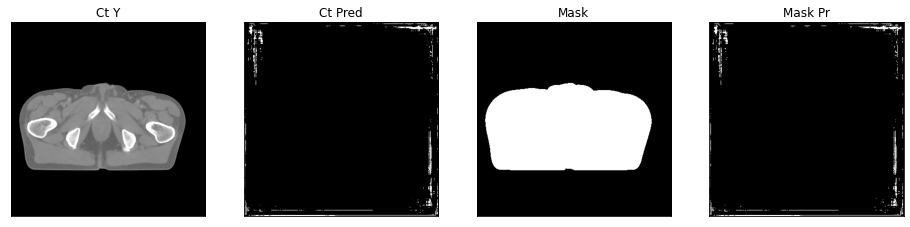

1it [00:00,  1.66it/s]

ssim score = 0.5285466909408569
psnr score = 8.754385948181152
snr score = -0.8426902294158936
mae error = 0.20887918770313263
mask dice score = 1.909380787806867e-12


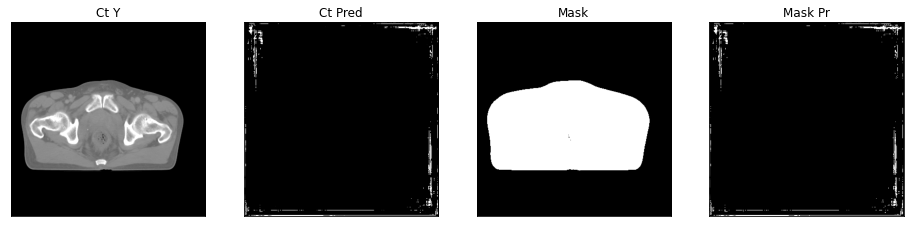

2it [00:00,  1.98it/s]

ssim score = 0.5346019864082336
psnr score = 8.879343032836914
snr score = -0.8853466510772705
mae error = 0.2038130909204483
mask dice score = 1.945563143248029e-12


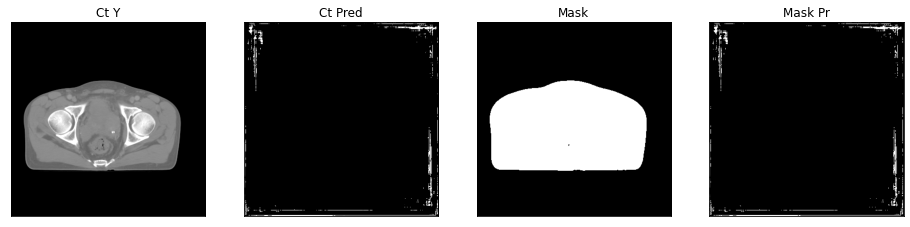

3it [00:01,  2.29it/s]

ssim score = 0.5429448485374451
psnr score = 8.881911277770996
snr score = -0.8740048408508301
mae error = 0.2016502469778061
mask dice score = 1.9901289603526706e-12


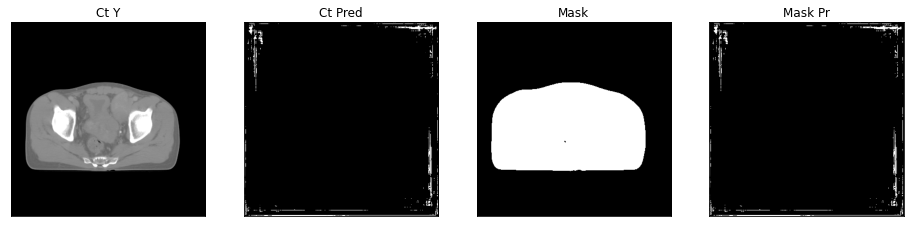

4it [00:01,  2.60it/s]

ssim score = 0.5576602220535278
psnr score = 9.049077033996582
snr score = -0.9135151505470276
mae error = 0.19452564418315887
mask dice score = 2.0658169272996344e-12


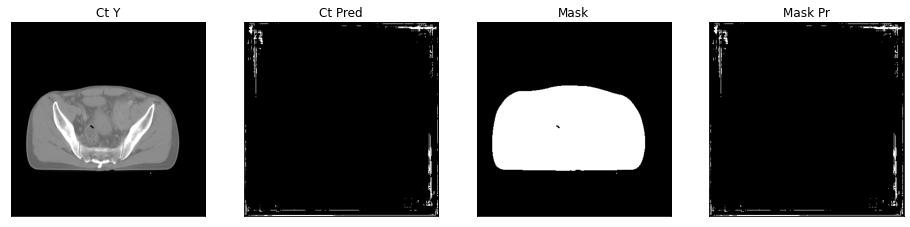

5it [00:01,  2.82it/s]

ssim score = 0.5761635303497314
psnr score = 9.240784645080566
snr score = -0.9514068961143494
mae error = 0.18523791432380676
mask dice score = 2.179361447091251e-12


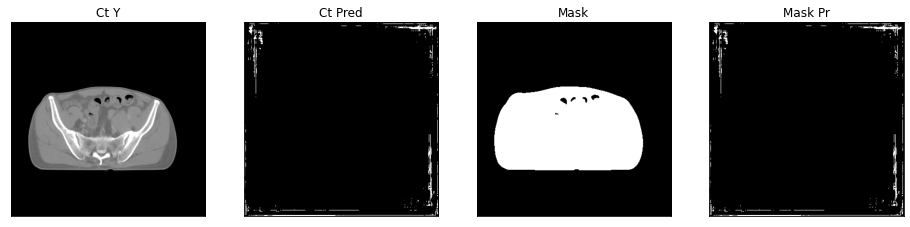

6it [00:01,  3.02it/s]

ssim score = 0.5944297313690186
psnr score = 9.438322067260742
snr score = -0.9922909736633301
mae error = 0.1752374768257141
mask dice score = 2.314118436576229e-12


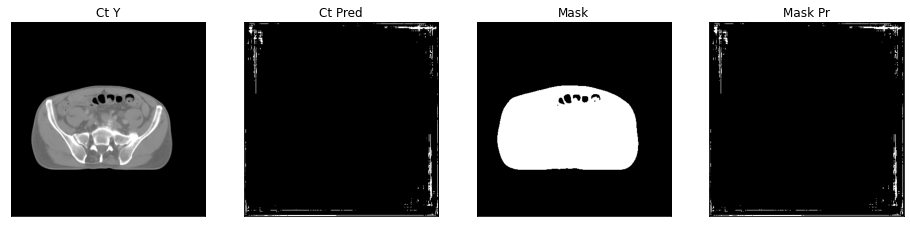

7it [00:22,  6.39s/it]

ssim score = 0.3369133770465851
psnr score = 8.003660202026367
snr score = -0.6241821050643921
mae error = 0.28825128078460693
mask dice score = 0.009790379257227928


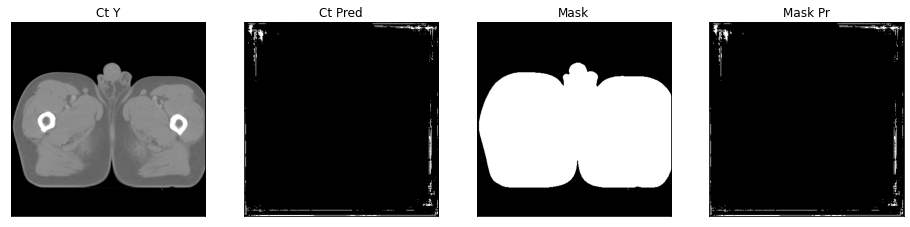

8it [00:22,  4.56s/it]

ssim score = 0.325297087430954
psnr score = 7.647017955780029
snr score = -0.563418447971344
mae error = 0.30313313007354736
mask dice score = 0.009979780304111362


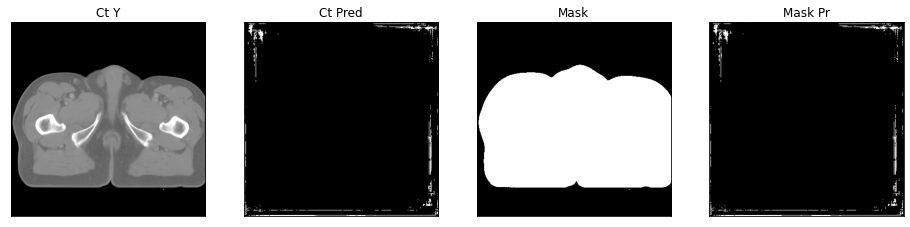

9it [00:23,  3.27s/it]

ssim score = 0.31909090280532837
psnr score = 7.529068470001221
snr score = -0.534582257270813
mae error = 0.3083288371562958
mask dice score = 0.00979956498466941


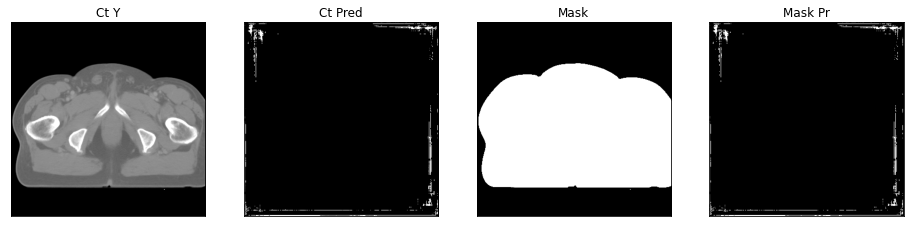

10it [00:23,  2.38s/it]

ssim score = 0.3177183270454407
psnr score = 7.271933078765869
snr score = -0.5046567320823669
mae error = 0.3176336884498596
mask dice score = 0.010263707298883514


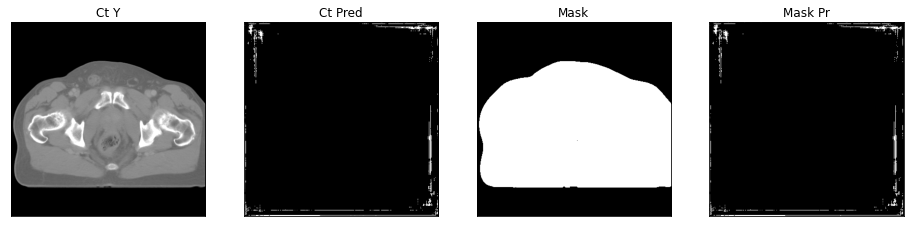

11it [00:23,  1.75s/it]

ssim score = 0.3233225643634796
psnr score = 7.510168075561523
snr score = -0.5429391860961914
mae error = 0.3082289695739746
mask dice score = 0.011540912417677726


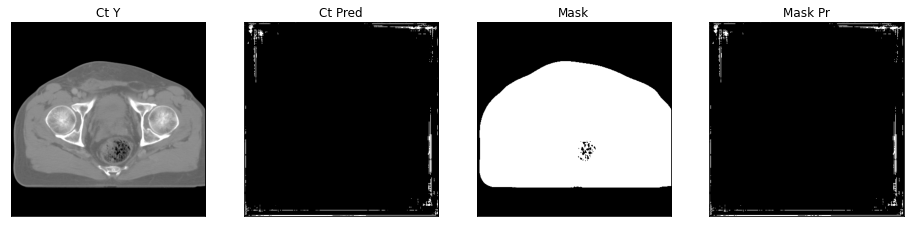

12it [00:23,  1.31s/it]

ssim score = 0.3342428505420685
psnr score = 7.513753890991211
snr score = -0.5426253080368042
mae error = 0.3039177358150482
mask dice score = 0.011090173675227036


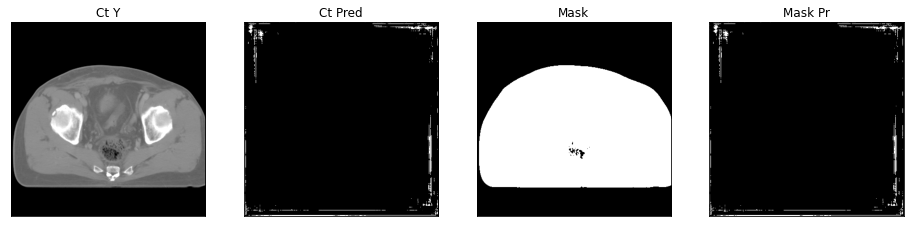

13it [00:24,  1.00it/s]

ssim score = 0.3331727385520935
psnr score = 7.418346881866455
snr score = -0.5252816677093506
mae error = 0.3058885633945465
mask dice score = 0.010164540001436358


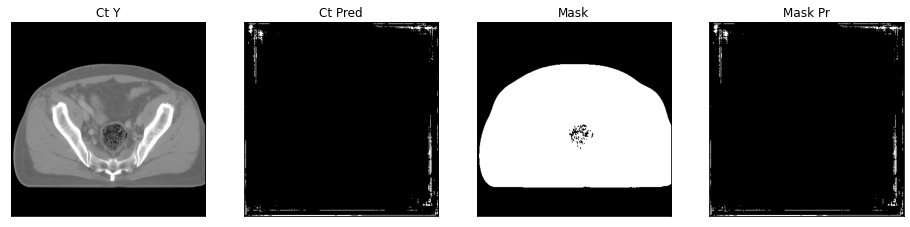

14it [00:24,  1.28it/s]

ssim score = 0.4988352358341217
psnr score = 9.045074462890625
snr score = -0.8617374897003174
mae error = 0.21217747032642365
mask dice score = 0.0025738682822862664


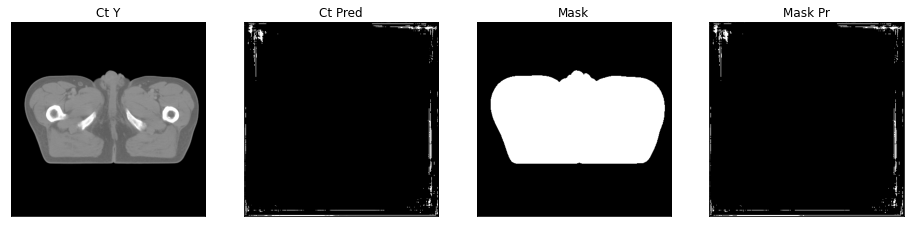

15it [00:24,  1.58it/s]

ssim score = 0.49373137950897217
psnr score = 8.84272575378418
snr score = -0.8093626499176025
mae error = 0.21837563812732697
mask dice score = 0.0027845577383155407


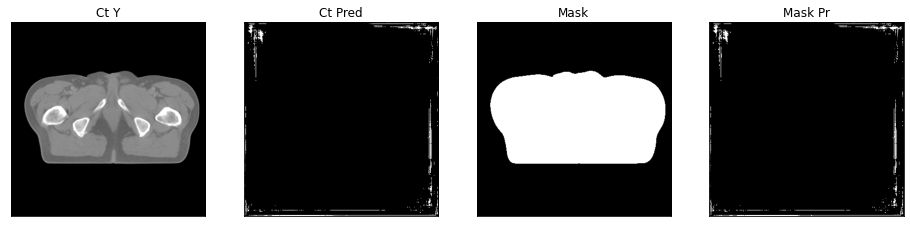

16it [00:25,  1.91it/s]

ssim score = 0.48773449659347534
psnr score = 8.703043937683105
snr score = -0.7848696708679199
mae error = 0.22321267426013947
mask dice score = 0.0028557344183942346


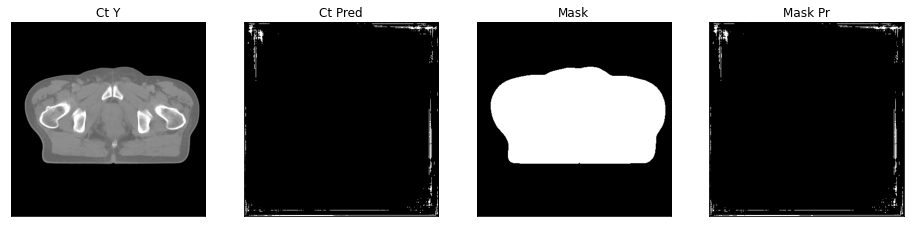

17it [00:25,  2.22it/s]

ssim score = 0.4854141175746918
psnr score = 8.557579040527344
snr score = -0.7609688639640808
mae error = 0.22747370600700378
mask dice score = 0.002398608133304507


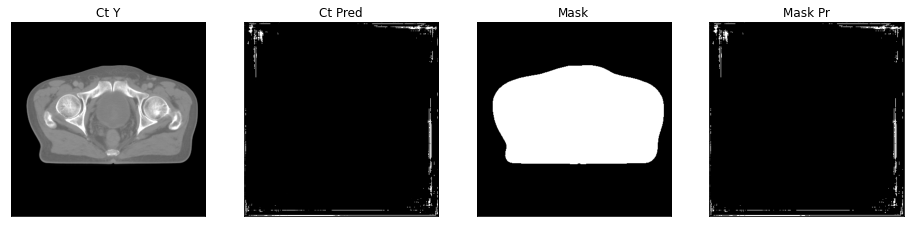

18it [00:25,  2.50it/s]

ssim score = 0.4803723990917206
psnr score = 8.761157989501953
snr score = -0.8309490084648132
mae error = 0.22305113077163696
mask dice score = 0.0011702750162983025


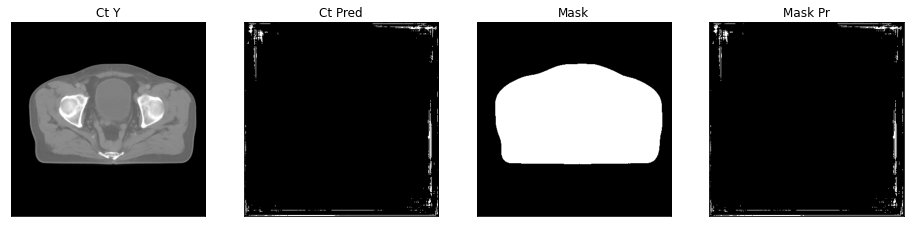

19it [00:25,  2.77it/s]

ssim score = 0.47809845209121704
psnr score = 8.735395431518555
snr score = -0.8266138434410095
mae error = 0.225326269865036
mask dice score = 0.0003634501346411534


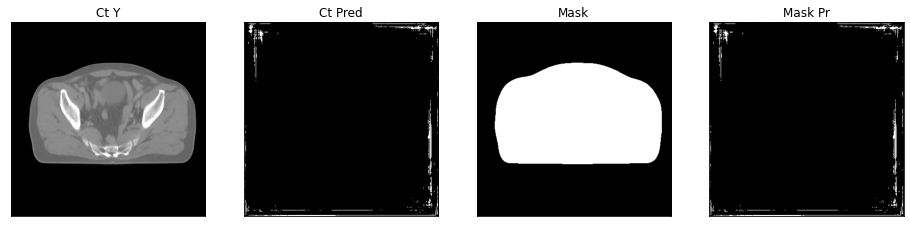

20it [00:26,  2.99it/s]

ssim score = 0.4765511453151703
psnr score = 8.634654998779297
snr score = -0.791110634803772
mae error = 0.22783984243869781
mask dice score = 1.6543965588524204e-12


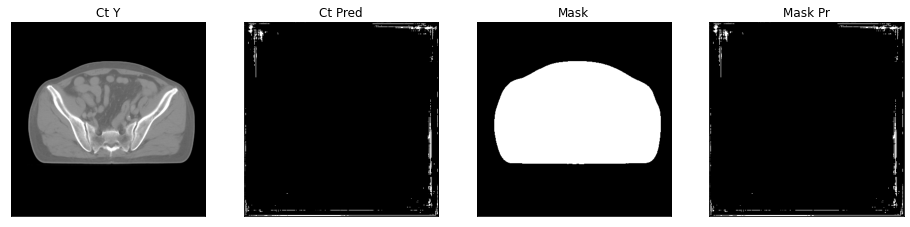

21it [00:26,  3.13it/s]

ssim score = 0.41992127895355225
psnr score = 8.445488929748535
snr score = -0.7952806353569031
mae error = 0.24654027819633484
mask dice score = 0.00032920825564468077


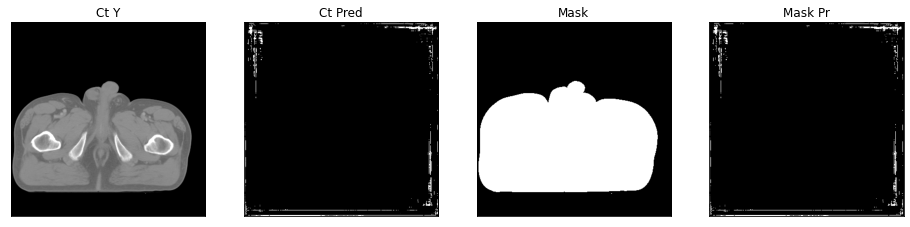

22it [00:26,  3.27it/s]

ssim score = 0.4275156855583191
psnr score = 8.458708763122559
snr score = -0.7775863409042358
mae error = 0.24490880966186523
mask dice score = 0.002836023534465476


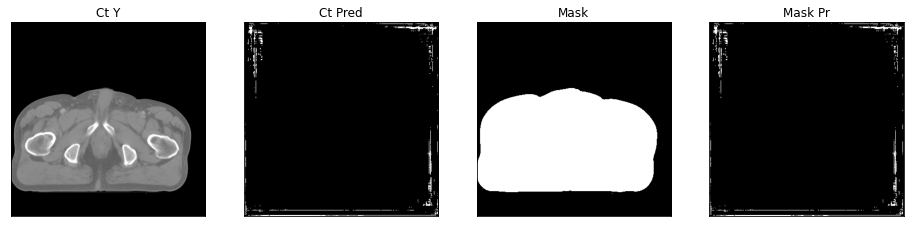

23it [00:26,  3.37it/s]

ssim score = 0.42751652002334595
psnr score = 8.268882751464844
snr score = -0.7498473525047302
mae error = 0.25031548738479614
mask dice score = 0.003740742418203326


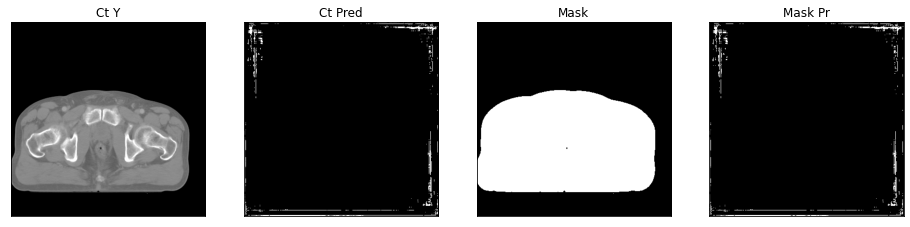

24it [00:27,  3.44it/s]

ssim score = 0.43140995502471924
psnr score = 8.417366027832031
snr score = -0.7787598371505737
mae error = 0.24517351388931274
mask dice score = 0.004612280197532109


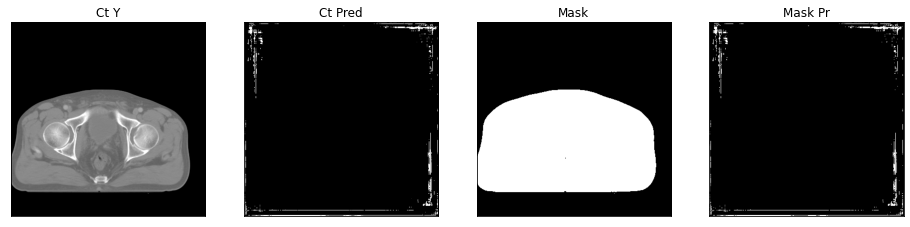

25it [00:27,  3.45it/s]

ssim score = 0.43951335549354553
psnr score = 8.53211498260498
snr score = -0.7887539267539978
mae error = 0.2381954789161682
mask dice score = 0.0046603389635333755


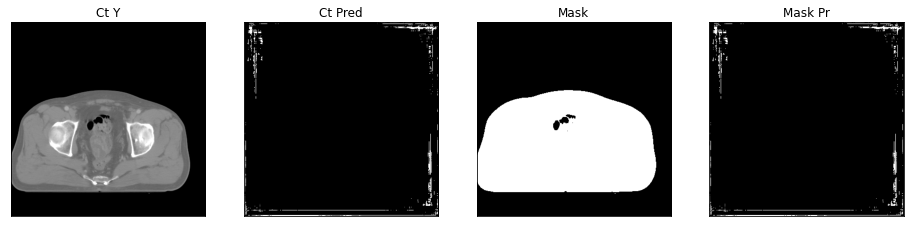

26it [00:27,  3.53it/s]

ssim score = 0.4545849859714508
psnr score = 8.692776679992676
snr score = -0.8269102573394775
mae error = 0.22913220524787903
mask dice score = 0.0036590894388257573


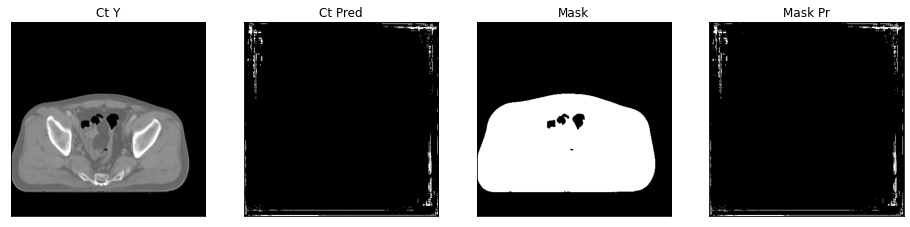

27it [00:28,  3.55it/s]

ssim score = 0.46674686670303345
psnr score = 8.684884071350098
snr score = -0.8460128903388977
mae error = 0.22545626759529114
mask dice score = 0.00023409022673271228


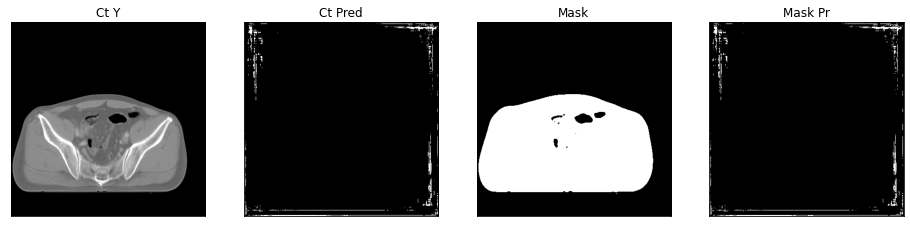

28it [00:28,  3.55it/s]

ssim score = 0.3179650604724884
psnr score = 7.524731159210205
snr score = -0.5134255290031433
mae error = 0.31270354986190796
mask dice score = 0.012503604591945898


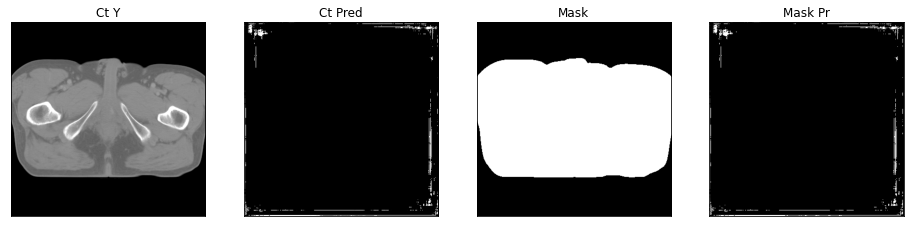

29it [00:28,  3.56it/s]

ssim score = 0.30613696575164795
psnr score = 7.406224250793457
snr score = -0.5078938007354736
mae error = 0.3187941014766693
mask dice score = 0.012687873759052403


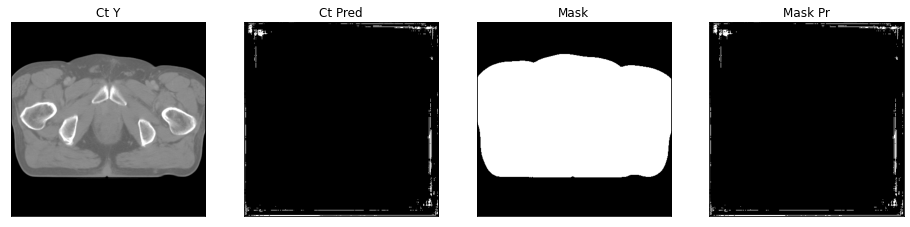

30it [00:29,  2.93it/s]

ssim score = 0.3026946485042572
psnr score = 7.254202365875244
snr score = -0.4875083565711975
mae error = 0.32529687881469727
mask dice score = 0.013826657615960821


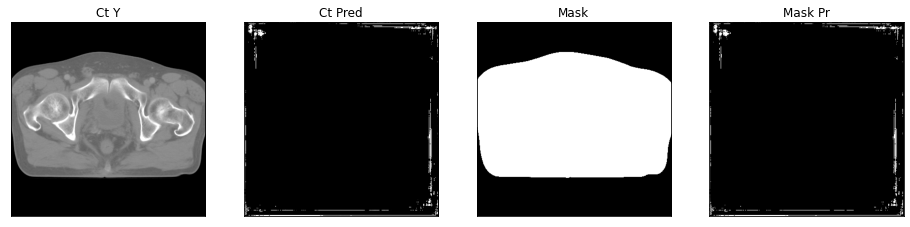

31it [00:29,  3.07it/s]

ssim score = 0.308055579662323
psnr score = 7.636094093322754
snr score = -0.5237247943878174
mae error = 0.30880072712898254
mask dice score = 0.014912100692004798


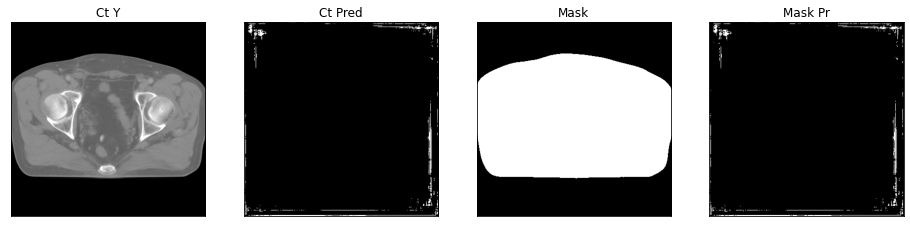

32it [00:29,  3.24it/s]

ssim score = 0.31556421518325806
psnr score = 7.749567031860352
snr score = -0.5567585229873657
mae error = 0.3021179735660553
mask dice score = 0.014192152438823458


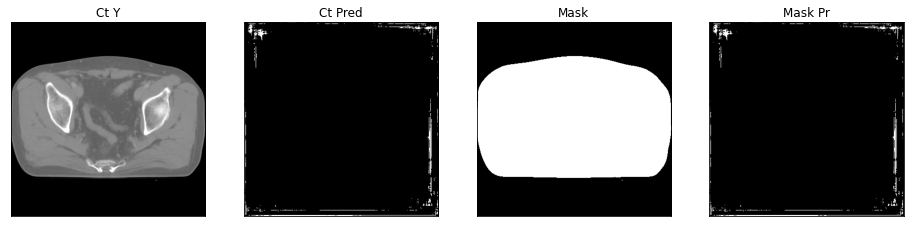

33it [00:29,  3.34it/s]

ssim score = 0.32417047023773193
psnr score = 7.579033851623535
snr score = -0.5589092373847961
mae error = 0.3051818907260895
mask dice score = 0.012367995434530056


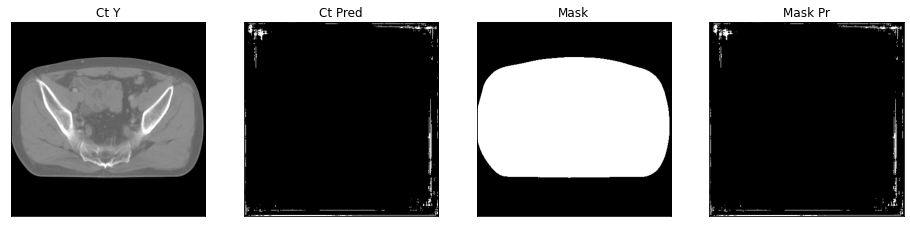

34it [00:30,  3.39it/s]

ssim score = 0.40634942054748535
psnr score = 7.929518699645996
snr score = -0.5930900573730469
mae error = 0.2708514928817749
mask dice score = 0.010212623473672898


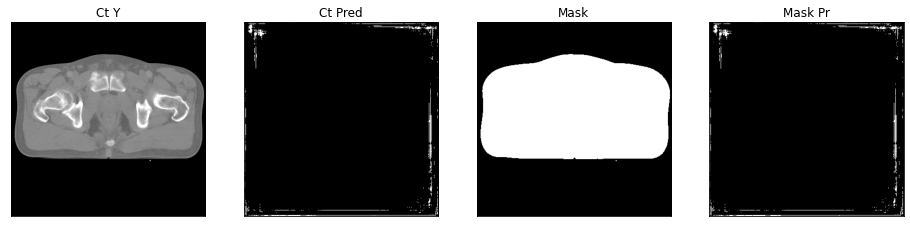

35it [00:30,  3.44it/s]

ssim score = 0.4075801968574524
psnr score = 8.048965454101562
snr score = -0.6398879885673523
mae error = 0.26700764894485474
mask dice score = 0.010068381089608495


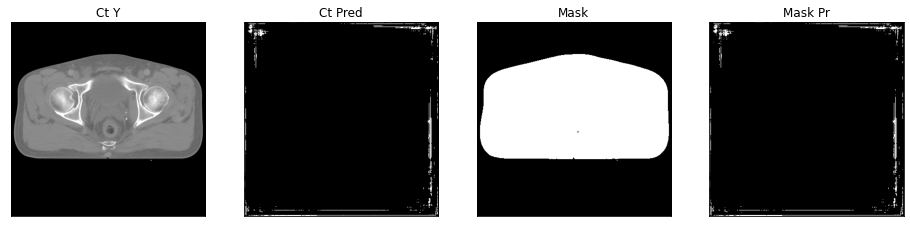

36it [00:30,  3.53it/s]

ssim score = 0.4150696098804474
psnr score = 8.030372619628906
snr score = -0.6297698020935059
mae error = 0.265140175819397
mask dice score = 0.009831500583908971


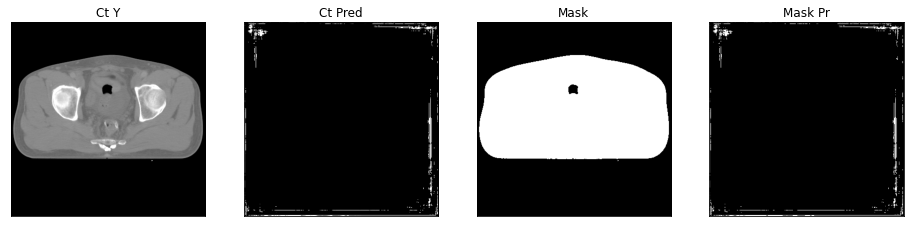

37it [00:31,  3.53it/s]

ssim score = 0.42350223660469055
psnr score = 8.15869140625
snr score = -0.6391450762748718
mae error = 0.2589450478553772
mask dice score = 0.009764153678203389


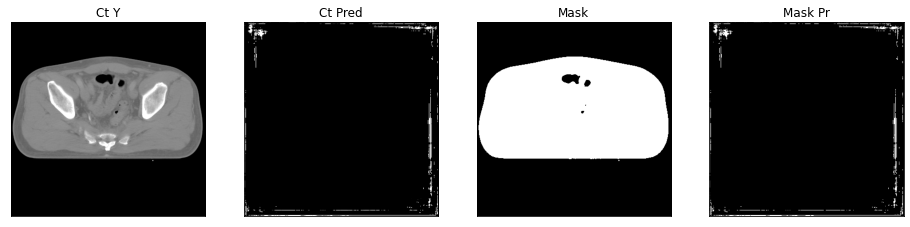

38it [00:31,  3.53it/s]

ssim score = 0.42940273880958557
psnr score = 8.124574661254883
snr score = -0.6400682926177979
mae error = 0.25739145278930664
mask dice score = 0.00873233619640568


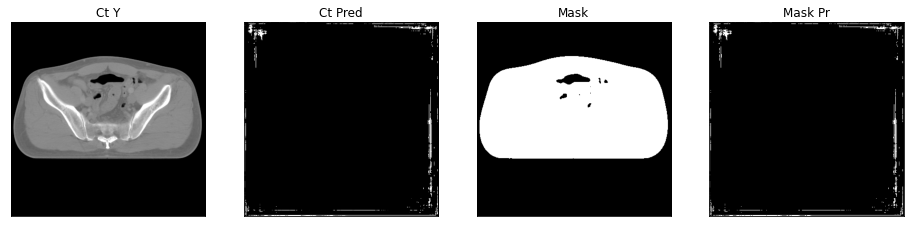

39it [00:31,  3.58it/s]

ssim score = 0.4263561964035034
psnr score = 8.15981674194336
snr score = -0.6374896168708801
mae error = 0.25585442781448364
mask dice score = 0.006981525583139347


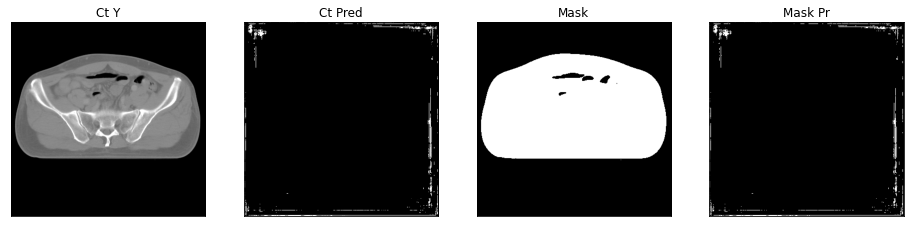

40it [00:31,  3.60it/s]

ssim score = 0.4197324216365814
psnr score = 8.250597953796387
snr score = -0.6823410987854004
mae error = 0.2539249360561371
mask dice score = 0.004358891848280785


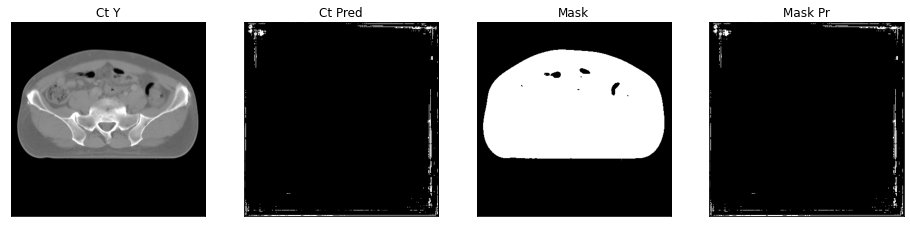

41it [00:32,  3.58it/s]

ssim score = 0.4073967933654785
psnr score = 8.821717262268066
snr score = -0.7973699569702148
mae error = 0.24153508245944977
mask dice score = 0.005714929198212726


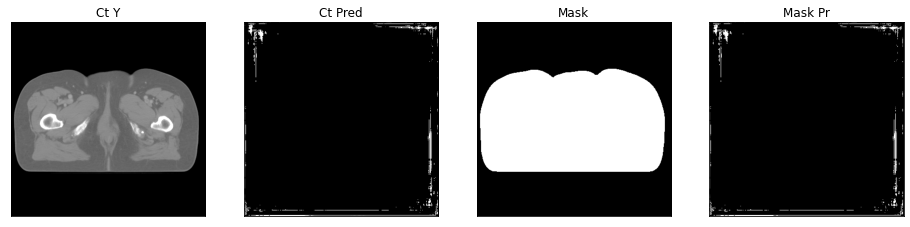

42it [00:32,  3.63it/s]

ssim score = 0.4008581042289734
psnr score = 8.58948802947998
snr score = -0.7337644100189209
mae error = 0.24999907612800598
mask dice score = 0.007047898069418966


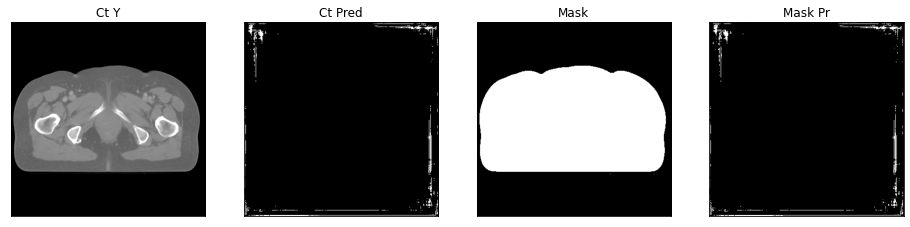

43it [00:32,  3.64it/s]

ssim score = 0.39788705110549927
psnr score = 8.479860305786133
snr score = -0.6980031132698059
mae error = 0.25417986512184143
mask dice score = 0.008883770668464144


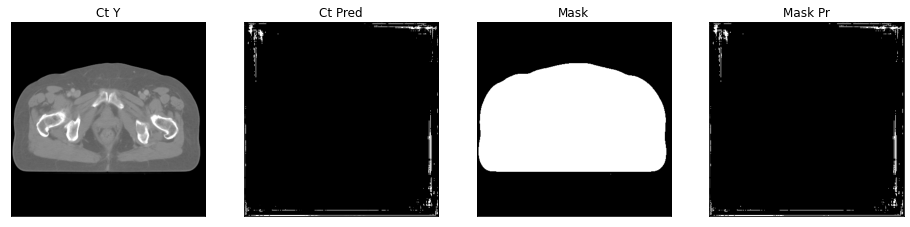

44it [00:32,  3.67it/s]

ssim score = 0.3954029083251953
psnr score = 8.501060485839844
snr score = -0.7138011455535889
mae error = 0.2548746168613434
mask dice score = 0.011097326554496738


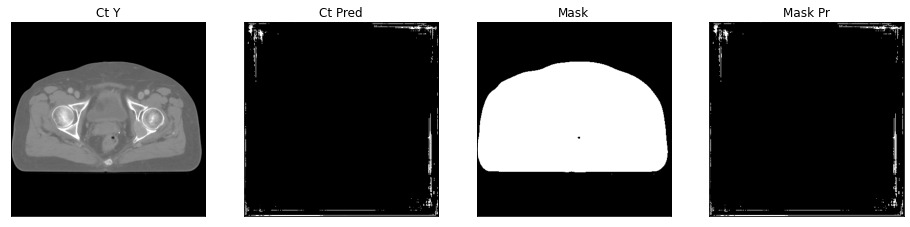

45it [00:33,  3.64it/s]

ssim score = 0.38497552275657654
psnr score = 8.471363067626953
snr score = -0.692908763885498
mae error = 0.2567169666290283
mask dice score = 0.013339927554016895


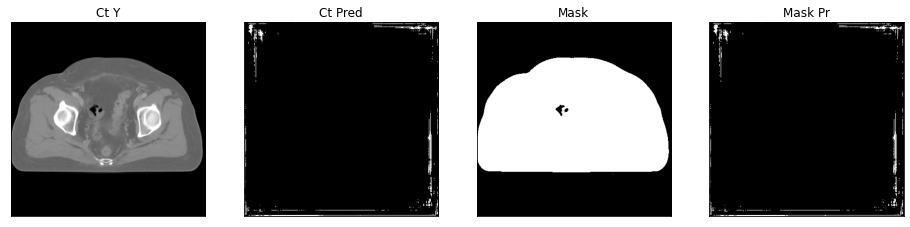

46it [00:33,  3.66it/s]

ssim score = 0.36033889651298523
psnr score = 8.482500076293945
snr score = -0.6697297096252441
mae error = 0.26251697540283203
mask dice score = 0.013364002005868129


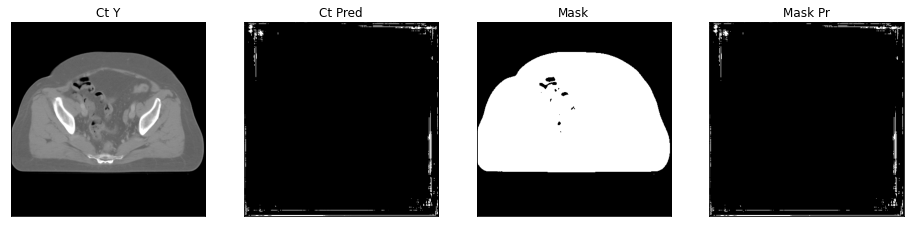

47it [00:33,  3.64it/s]

ssim score = 0.3470935821533203
psnr score = 8.32625675201416
snr score = -0.6378784775733948
mae error = 0.2698269486427307
mask dice score = 0.012684936325371524


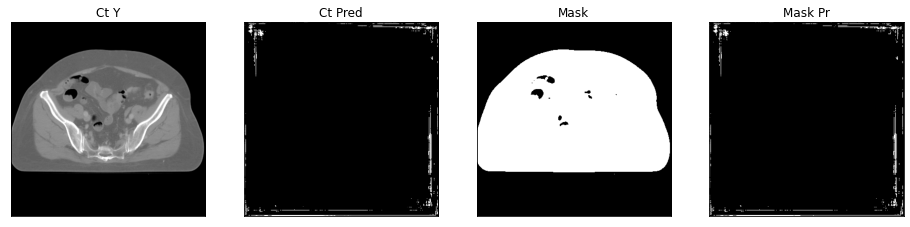

48it [00:34,  1.40it/s]


In [35]:
test_epoch(model, testloader, device, True, os.path.join("eval-autoencoder", run_name))

In [36]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test
eval_epoch(model, testloader, device)

48it [00:05,  9.01it/s]


(0.4171646560231845,
 8.288496643304825,
 -0.7038930281996727,
 0.2558292414372166,
 0.006738686402142678)